In [93]:
using Images
using Statistics
using Plots
using DSP
using StatsBase
using VectorizedStatistics
using ImageMorphology

In [133]:
function mask_site(file, threshold; n_sites=1)
    img = load(file)
    im_array = Float64.(img) * 65535 # concert to 16bit
    # Don't do frame averaging. Was found not neccessary for images used. 
    # Use stack standard dev projection to find polarity patch(es)
    img_std = std(im_array, dims=(3))[:,:,1]
    max_bin = 0
    bin = img_std .> maximum(img_std)*threshold
    bin = dilate(bin, r=1)
    bin_lab = label_components(bin)
    masks = zeros(size(im_array)[1], size(im_array)[2], size(im_array)[3], n_sites)
    for i in range(1,n_sites)
        bin = bin .- max_bin         
        max_loc = findmax(bin.*img_std)[2]          # mask the image. find the max. get the coords.
        max_lab = bin_lab[max_loc]                  # get label in labeled mask from coords
        max_bin = bin_lab .== max_lab               # Make binary mask only around correct component
        im_masked = im_array .* max_bin 
        masks[:,:,:,i] = im_masked
    end
    return masks
end

mask_site (generic function with 1 method)

In [167]:
# Modified for mutli-signal to return times instead of time-crops
function crop_times(signal, frames, thresh)
    signal=signal.-minimum(signal)
    start = Integer(findall(signal .> ((maximum(signal))*thresh))[1])
    if start + frames < length(signal)
        times = start:start+Integer(frames)
        return times
    else 
        last = length(signal)
        times = last-Integer(frames):last
        print(".")
        return times
    end
end

crop_times (generic function with 1 method)

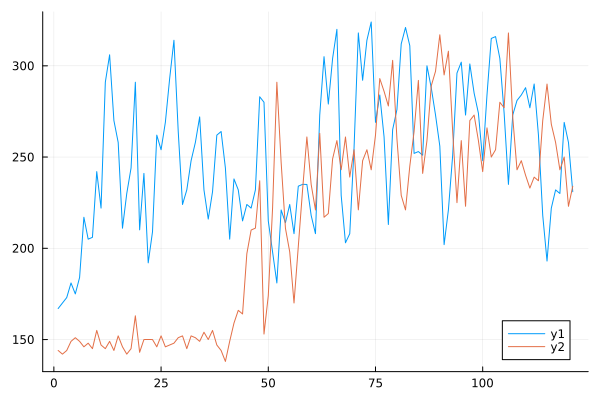

In [168]:
file = "../movies-Pak1-GFP/2024_09_26/2patch/Movie055-cell5.tif"
masks = mask_site(file, 0.5, n_sites=2);
im_size = length(masks[:,1,1,1])*length(masks[1,:,1,1])
m1 = masks[:,:,:,1]
m2 = masks[:,:,:,2]
q1 = vquantile(m1, (im_size-5)/im_size, dims=(1,2))[1,1,:]
q2 = vquantile(m2, (im_size-5)/im_size, dims=(1,2))[1,1,:]
plot(q1)
plot!(q2)
#crop_times(masks[:,:,:,1])

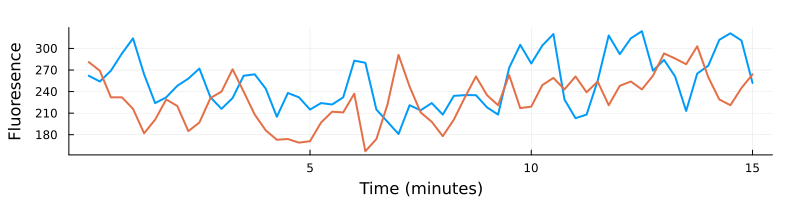

In [182]:
file = "../movies-Pak1-GFP/2024_09_26/2patch/Movie055-cell5.tif"
interval = 15
time_threshold=0.5
masks = mask_site(file, 0.3, n_sites=2);
im_size = length(masks[:,1,1,1])*length(masks[1,:,1,1])
m1 = masks[:,:,:,1]
m2 = masks[:,:,:,2]
q1 = vquantile(m1, (im_size-5)/im_size, dims=(1,2))[1,1,:]
q2 = vquantile(m2, (im_size-5)/im_size, dims=(1,2))[1,1,:]
times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
times_max2 = crop_times(q2, 15*(60/interval), time_threshold)
crop1 = q1[max(times_max1, times_max2)]
crop2 = q2[max(times_max1, times_max2)]
t = range(0,60/15*15)*(15/60) # Convert from 1 frame every 5 sec, to minutes
plot(t, crop1, xticks=range(1,6)*5, linewidth=2, label=false, 
    xlabel="Time (minutes)", ylabel="Fluoresence", size=(800,200), margin=5Plots.mm)
plot!(t, crop2, xticks=range(1,6)*5, linewidth=2, label=false)
#savefig("../figures/Pak1GFP_2site_m55c5.png")

..

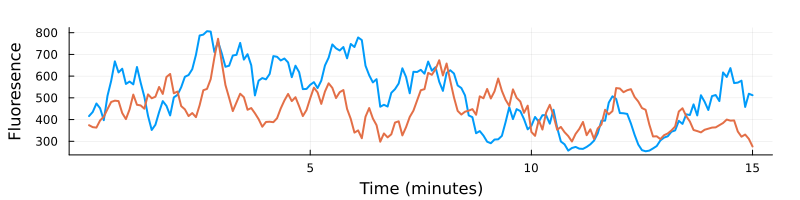

In [291]:
file = "../movies-Pak1-GFP/2024_09_26/2patch/Movie022-cell2.tif"
file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/movie2-cell4.tif"
interval = 5
cov_threshold=0.3
time_threshold=.5
masks = mask_site(file, cov_threshold, n_sites=2);
im_size = length(masks[:,1,1,1])*length(masks[1,:,1,1])
m1 = masks[:,:,:,1]
m2 = masks[:,:,:,2]
q1 = vquantile(m1, (im_size-5)/im_size, dims=(1,2))[1,1,:]
q2 = vquantile(m2, (im_size-5)/im_size, dims=(1,2))[1,1,:]
times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
times_max2 = crop_times(q2, 15*(60/interval), time_threshold)
crop1 = q1[max(times_max1, times_max2)]
crop2 = q2[max(times_max1, times_max2)]
t = range(0,60/5*15)*(5/60) # Convert from 1 frame every 5 sec, to minutes
plot(t, crop1, xticks=range(1,6)*5, linewidth=2, label=false, 
    xlabel="Time (minutes)", ylabel="Fluoresence", size=(800,200), margin=5Plots.mm)
plot!(t, crop2, xticks=range(1,6)*5, linewidth=2, label=false)
#savefig("../figures/Pak1GFP_2site_m55c1.png")

........xyxyxy.xyxyxyxy

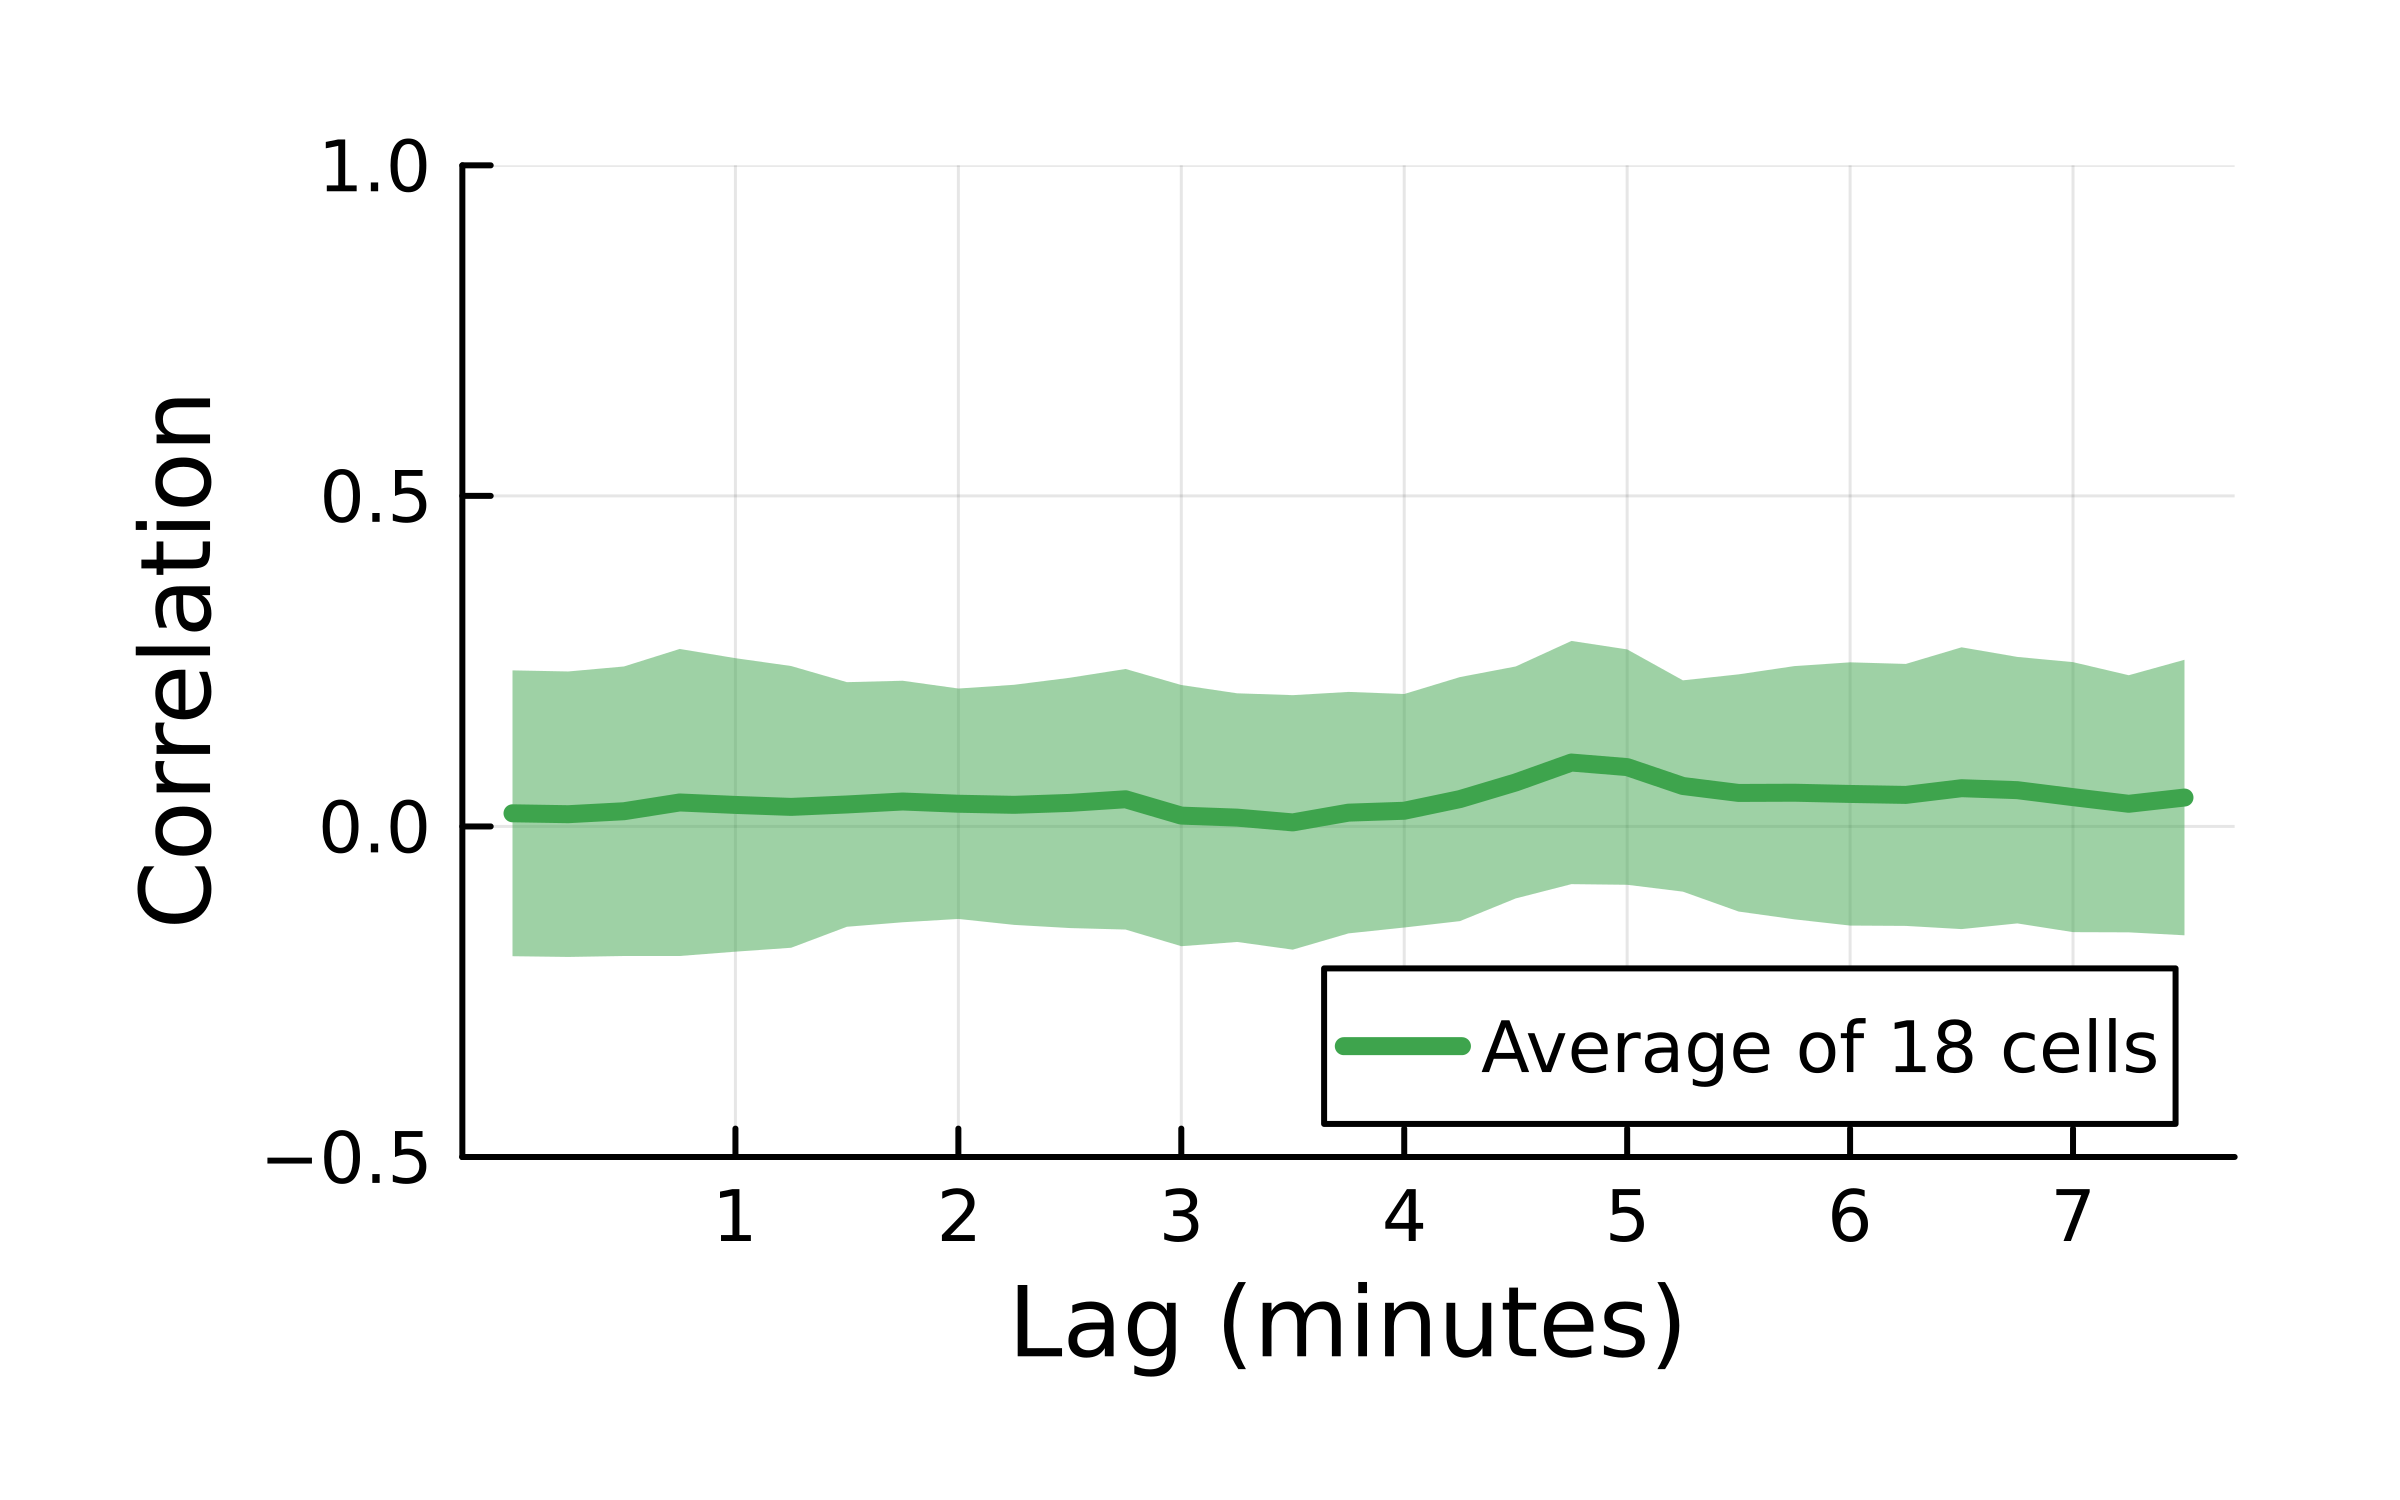

In [300]:
dir = "../movies-Pak1-GFP/2024_09_26/2patch/"
wt_files = readdir(dir)
dir5sec = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/"
more_files = readdir(dir5sec)
plot(ylabel="Correlation", xlabel="Lag (minutes)",
    legend=:bottomright, size=(600,400))
all_cor = zeros(31, ((length(wt_files)+length(more_files))*2))
t_cor = range(0,30)*(15/60)
n = 0
for f in wt_files
    patches = mask_site("$dir$f", cov_threshold, n_sites=2)
    patch1 = patches[:,:,:,1]
    patch2 = patches[:,:,:,2]
    if length(patches) > 200 # These are 5 second movies
        patch1=patch1[:,:,range(1,Int((length(patch1[1,1,:])/3)*3))]
        patch2=patch2[:,:,range(1,Int((length(patch2[1,1,:])/3)*3))] # Take every 3rd frame.
    end
    max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
    max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
    times_max1 = crop_times(max_patch1, 15*(60/15), 0.5)
    times_max2 = crop_times(max_patch2, 15*(60/15), 0.5)
    crop1 = max_patch1[max(times_max1, times_max2)]
    crop2 = max_patch2[max(times_max1, times_max2)]
    cor1 = crosscor(crop1, crop2, -30:0)
    cor2 = crosscor(crop1, crop2, 0:30)
    all_cor[:,n+1] = cor1
    all_cor[:,n+2] = cor2
    n+=2
end

for f in more_files
    patches = mask_site("$dir5sec$f", cov_threshold, n_sites=2)
    patch1 = patches[:,:,:,1]
    patch2 = patches[:,:,:,2]
    max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
    max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
    times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
    times_max2 = crop_times(max_patch2, 15*(60/5), 0.5)
    crop1 = max_patch1[max(times_max1, times_max2)]
    crop2 = max_patch2[max(times_max1, times_max2)]
    cor1 = crosscor(crop1, crop2, -90:0)
    cor2 = crosscor(crop1, crop2, 0:90)
    print("x")
    all_cor[:,n+1] = cor1[range(0,30)*3 .+ 1]
    all_cor[:,n+2] = cor2[range(0,30)*3 .+ 1]
    n+=2
    print("y")
end

stdev = std(all_cor, dims=2)
plot!(t_cor, mean(all_cor, dims=2), ribbon=stdev, x_ticks=1:8, linewidth=3, color=3, alpha=1, 
    label="Average of $(Int(n/2)) cells", ylim=(-0.5,1), margin=5Plots.mm, dpi=600, size=(400,250))

#savefig("../figures/avg_xcorr.png")

.........

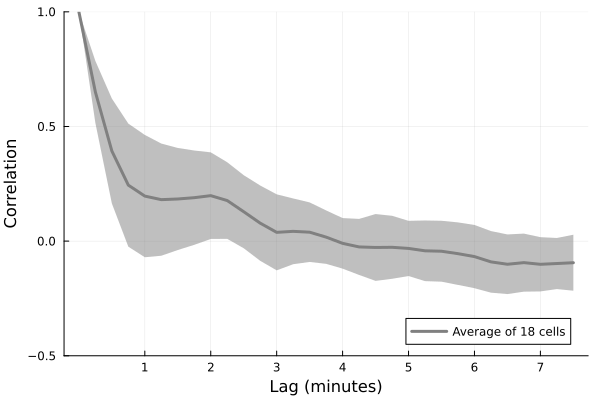

In [297]:
dir = "../movies-Pak1-GFP/2024_09_26/2patch/"
wt_files = readdir(dir)
dir5sec = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/"
more_files = readdir(dir5sec)
plot(ylabel="Correlation", xlabel="Lag (minutes)",
    legend=:bottomright, size=(600,400))
all_cor = zeros(31, ((length(wt_files)+length(more_files))*2))
peaks_ac = zeros((length(wt_files)+length(more_files))*2)
t_cor = range(0,30)*(15/60)
n = 0
for f in wt_files
    patches = mask_site("$dir$f", cov_threshold, n_sites=2)
    patch1 = patches[:,:,:,1]
    patch2 = patches[:,:,:,2]
    if length(patches) > 200 # These are 5 second movies
        patch1=patch1[:,:,range(1,Int((length(patch1[1,1,:])/3)*3))]
        patch2=patch2[:,:,range(1,Int((length(patch2[1,1,:])/3)*3))] # Take every 3rd frame.
    end
    max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
    max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
    times_max1 = crop_times(max_patch1, 15*(60/15), 0.5)
    times_max2 = crop_times(max_patch2, 15*(60/15), 0.5)
    crop1 = max_patch1[max(times_max1, times_max2)]
    crop2 = max_patch2[max(times_max1, times_max2)]
    cor1 = crosscor(crop1, crop1, 0:30)
    cor2 = crosscor(crop2, crop2, 0:30)
    all_cor[:,n+1] = cor1
    all_cor[:,n+2] = cor2
    n+=1
    mac = findlocalmaxima(cor1)[2]
    peaks_ac[n] = mac[1] * (15/60)
    n+=1
    mac = findlocalmaxima(cor2)[2]
    peaks_ac[n] = mac[1] * (15/60)
end

for f in more_files
    patches = mask_site("$dir5sec$f", cov_threshold, n_sites=2)
    patch1 = patches[:,:,:,1]
    patch2 = patches[:,:,:,2]
    max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
    max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
    times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
    times_max2 = crop_times(max_patch2, 15*(60/5), 0.5)
    crop1 = max_patch1[max(times_max1, times_max2)]
    crop2 = max_patch2[max(times_max1, times_max2)]
    cor1 = crosscor(crop1, crop1, 0:90)[range(0,30)*3 .+ 1]
    cor2 = crosscor(crop2, crop2, 0:90)[range(0,30)*3 .+ 1]
    all_cor[:,n+1] = cor1
    all_cor[:,n+2] = cor2
    n+=1
    mac = findlocalmaxima(cor1)[2]
    peaks_ac[n] = mac[1] * (15/60)
    n+=1
    mac = findlocalmaxima(cor2)[2]
    peaks_ac[n] = mac[1] * (15/60)
end

stdev = std(all_cor, dims=2)
plot!(t_cor, mean(all_cor, dims=2), ribbon=stdev, x_ticks=1:8, linewidth=3, color="grey", alpha=1, label="Average of $(Int(n/2)) cells", ylim=(-0.5,1))


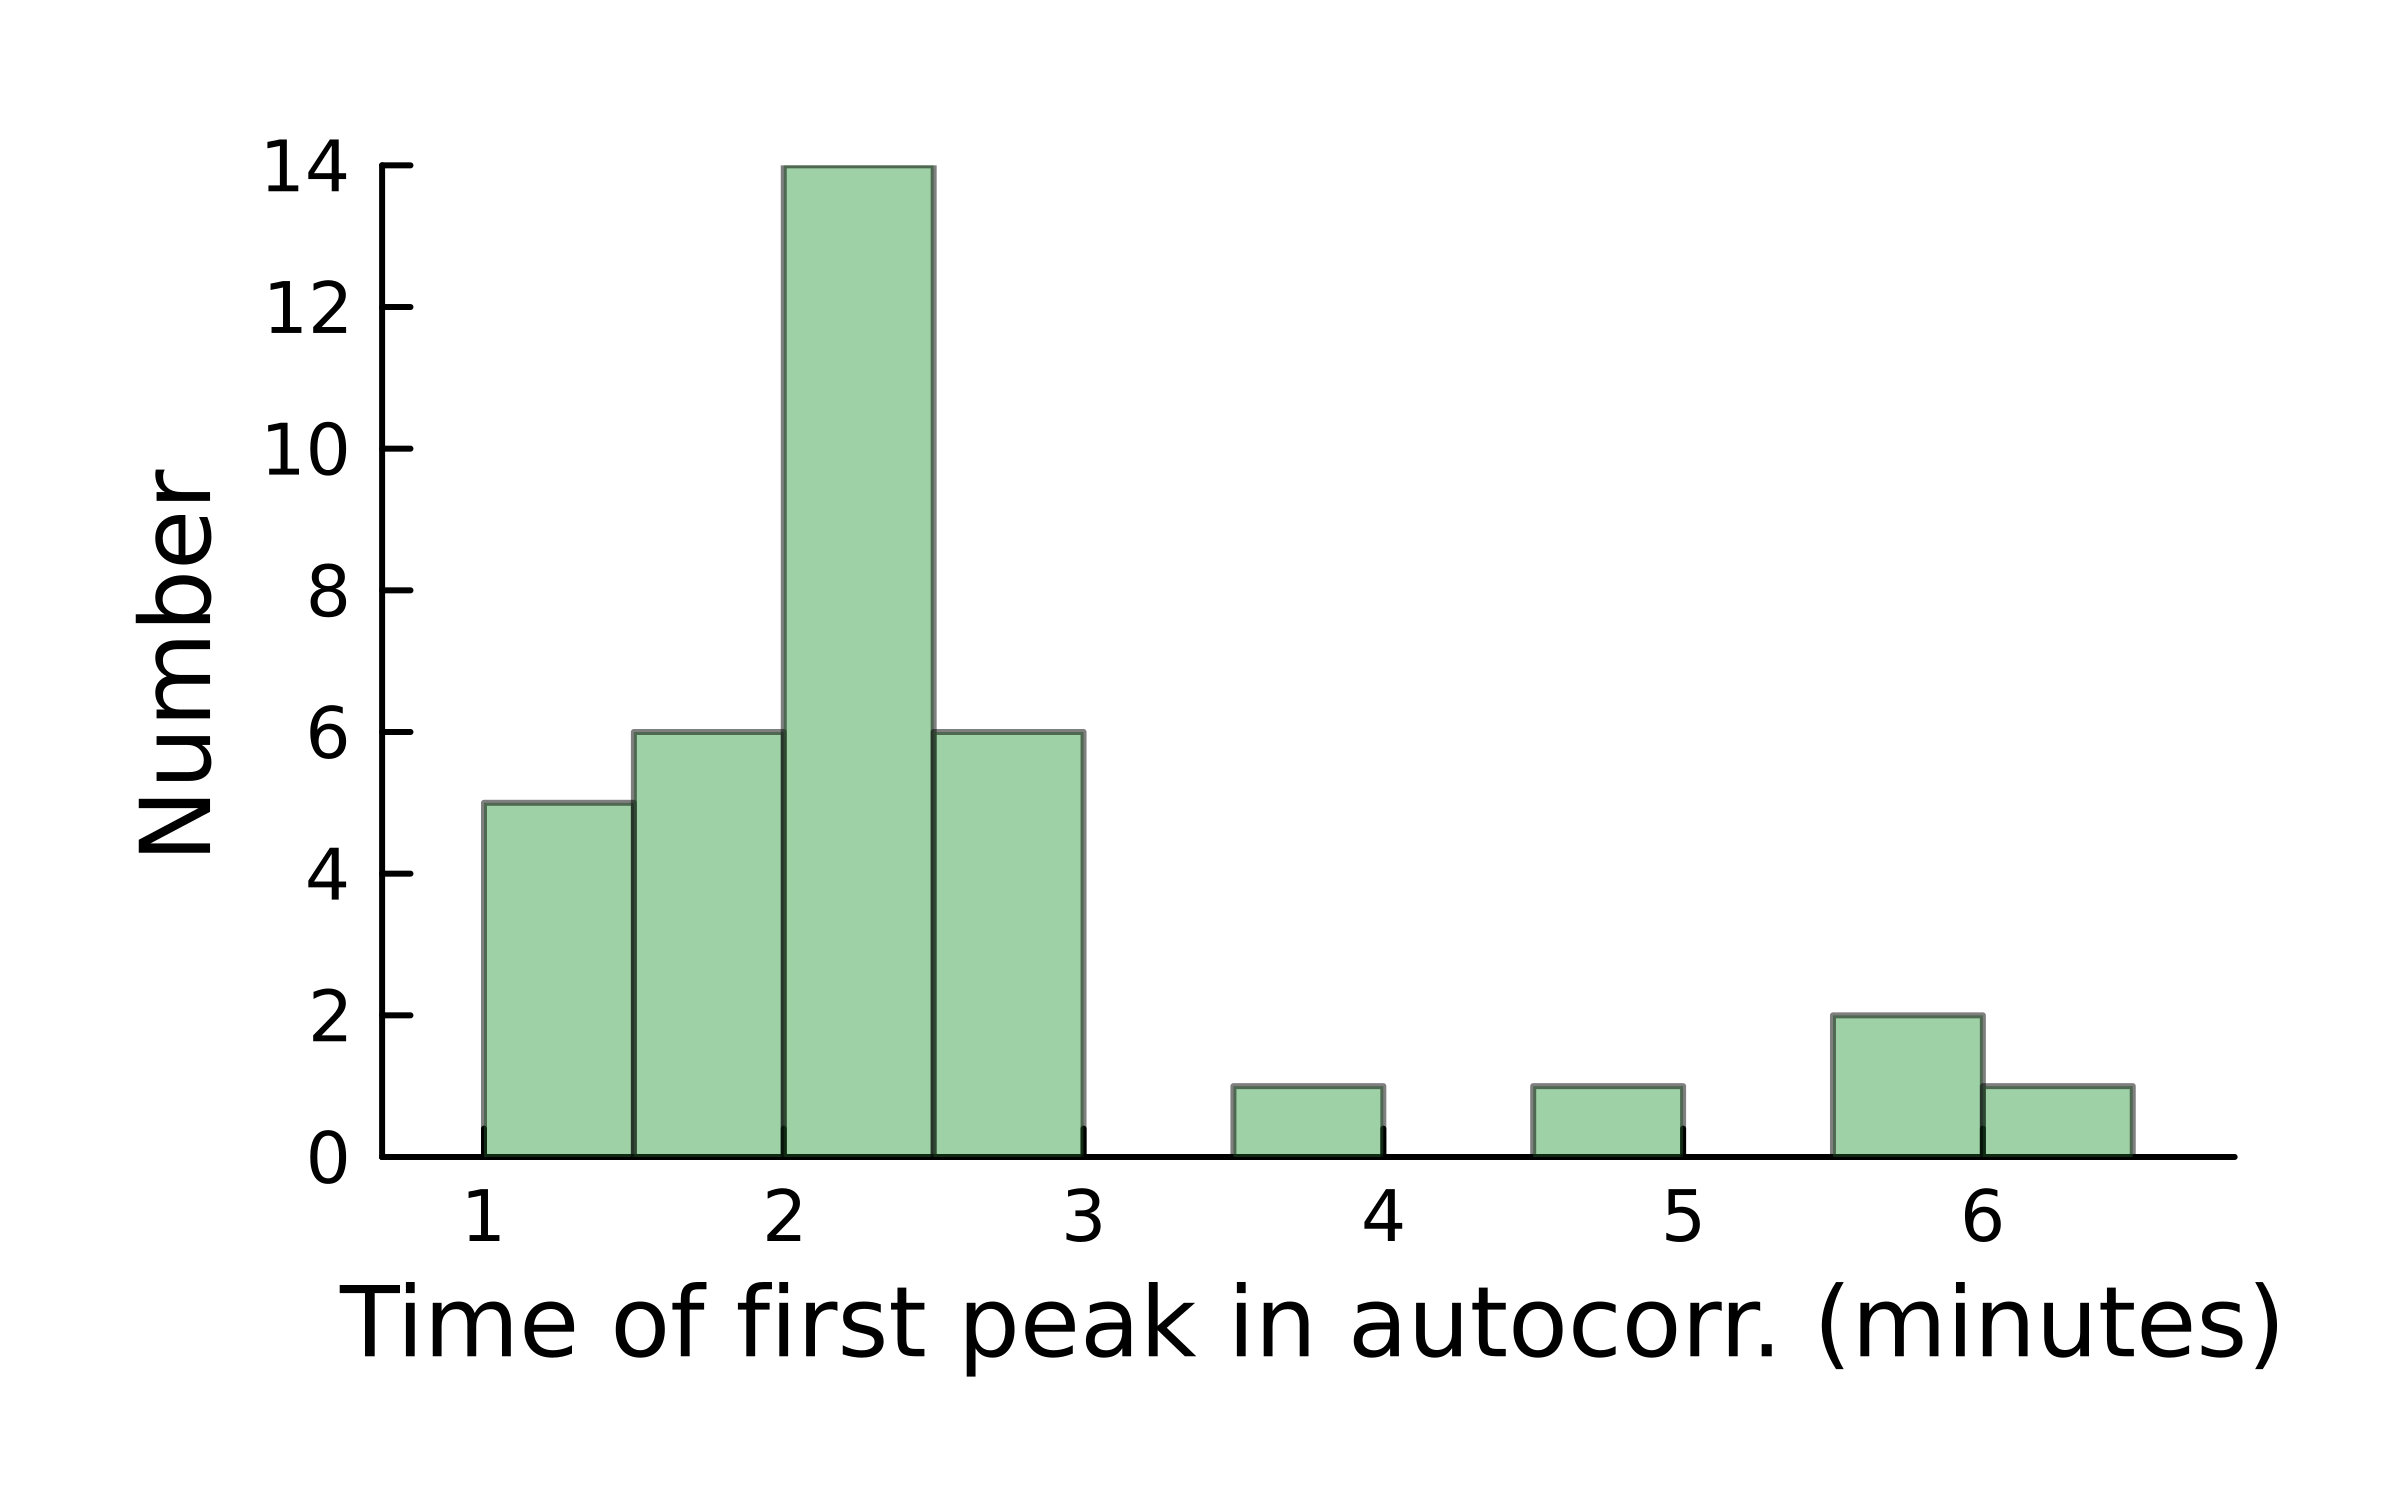

In [299]:
histogram(peaks_ac, alpha=0.5,bins=15, grid=false, legend=false, xticks=1:10, dpi=600, size=(400,250), color=3,
    xlabel="Time of first peak in autocorr. (minutes)", ylabel="Number", margin=5Plots.mm)
#savefig("../figures/Pak1GFP_xcor_period_histogram.png")

In [277]:
for f in wt_files
    interval = 15
    cov_threshold=0.3
    time_threshold=.5
    masks = mask_site("$dir$f", cov_threshold, n_sites=2)
    im_size = length(masks[:,1,1,1])*length(masks[1,:,1,1])
    m1 = masks[:,:,:,1]
    m2 = masks[:,:,:,2]
    q1 = vquantile(m1, (im_size-5)/im_size, dims=(1,2))[1,1,:]
    q2 = vquantile(m2, (im_size-5)/im_size, dims=(1,2))[1,1,:]
    times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
    times_max2 = crop_times(q2, 15*(60/interval), time_threshold)
    crop1 = q1[max(times_max1, times_max2)]
    crop2 = q2[max(times_max1, times_max2)]
    t = range(0,60/15*15)*(15/60) # Convert from 1 frame every 5 sec, to minutes

    cell = replace(f,".tif" => "")

    n+=1

    plot(size=(400,100))
    plot!(t, crop1, linewidth=2, label=false, dpi=600, grid=false, xticks=false, yticks=false, framestyle = :box)
    plot!(t, crop2, linewidth=2, label=false, dpi=600, grid=false, xticks=false, yticks=false, framestyle = :box)
    savefig("../figures/naked_2patch/$cell.png")
end

.........

In [295]:
for f in more_files
    interval = 5
    cov_threshold=0.3
    time_threshold=.5
    masks = mask_site("$dir5sec$f", cov_threshold, n_sites=2)
    im_size = length(masks[:,1,1,1])*length(masks[1,:,1,1])
    m1 = masks[:,:,:,1]
    m2 = masks[:,:,:,2]
    q1 = vquantile(m1, (im_size-5)/im_size, dims=(1,2))[1,1,:]
    q2 = vquantile(m2, (im_size-5)/im_size, dims=(1,2))[1,1,:]
    times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
    times_max2 = crop_times(q2, 15*(60/interval), time_threshold)
    crop1 = q1[max(times_max1, times_max2)]
    crop2 = q2[max(times_max1, times_max2)]
    t = range(0,60/5*15)*(5/60) # Convert from 1 frame every 5 sec, to minutes

    cell = replace(f,".tif" => "")

    n+=1

    plot(size=(400,100))
    plot!(t, crop1, linewidth=2, label=false, dpi=600, grid=false, xticks=false, yticks=false, framestyle = :box)
    plot!(t, crop2, linewidth=2, label=false, dpi=600, grid=false, xticks=false, yticks=false, framestyle = :box)
    savefig("../figures/naked_2patch/$cell.png")
end

..

ArgumentError: ArgumentError: No file exists at given path: ../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/movie3-cell1.tif

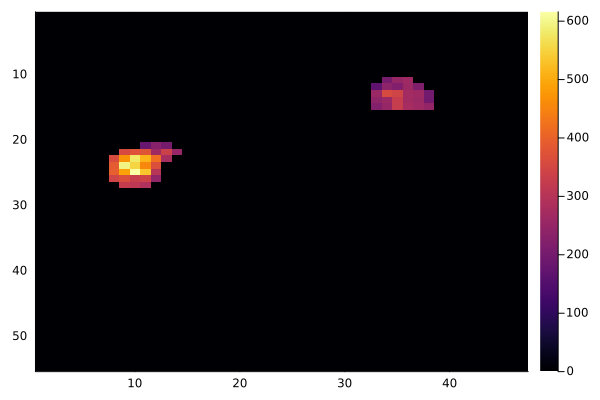

In [289]:
file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/movie2-cell4.tif"
img = load(file)
im_array = Float64.(img) * 65535 # concert to 16bit
    # Don't do frame averaging. Was found not neccessary for images used. 
    # Use stack standard dev projection to find polarity patch(es)    
img_std = std(im_array, dims=(3))[:,:,1]
using ImageMorphology
mask = img_std .> maximum(img_std)*0.3
heatmap(im_array[:,:,end] .* mask, yflip=true)

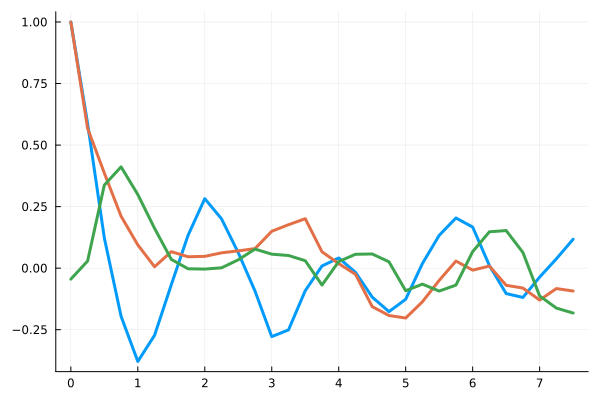

In [61]:
file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/movie2-cell1.tif" # bad. polarizes at very end of movie. 
file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/movie2-cell4.tif"
file = "../movies-Pak1-GFP/2024_09_26/2patch/Movie055-cell5.tif"
n=0
masks = mask_site(file, 0.5, n_sites=2)
im_size = length(masks[:,1,1,1])*length(masks[1,:,1,1])
m1 = masks[:,:,:,1]
m2 = masks[:,:,:,2]
q1 = vquantile(m1, (im_size-5)/im_size, dims=(1,2))[1,1,:]
q2 = vquantile(m2, (im_size-5)/im_size, dims=(1,2))[1,1,:]
times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
times_max2 = crop_times(q2, 15*(60/interval), time_threshold)
crop1 = q1[max(times_max1, times_max2)]
crop2 = q2[max(times_max1, times_max2)]
plot(crop1)
plot!(crop2)
ac1 = crosscor(crop1, crop1, 0:30)
ac2 = crosscor(crop2, crop2, 0:30)
xcor = crosscor(crop1, crop2, 0:30)
n+=2
t_cor = range(0,30)*(15/60)
plot(t_cor, ac1, x_ticks=0:8, label=false, color=1, linewidth=3)
plot!(t_cor, ac2, x_ticks=0:8, label=false, color=2, linewidth=3)
plot!(t_cor, xcor, x_ticks=0:8, label=false, color=3, linewidth=3)
#savefig("../figures/2patch_ac_2_4.png")

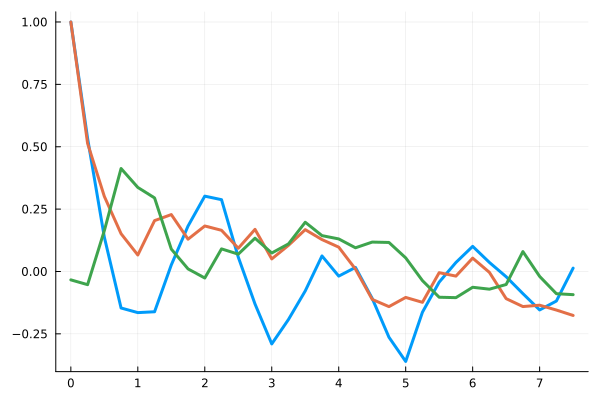

In [60]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/"
wt_files = readdir(dir)
plot(ylabel="Correlation", xlabel="Lag (minutes)",
    legend=:bottomright, size=(600,400))
all_cor = zeros(101, length(wt_files)*2)
t_cor = range(0,100)*(5/60)
n = 0
for f in wt_files
    patches = mask_site("$dir$f", n_sites=2)
    patch1 = patches[:,:,:,1]
    patch2 = patches[:,:,:,2]
    max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
    max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
    times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
    times_max2 = crop_times(max_patch2, 15*(60/5), 0.5)
    crop1 = max_patch1[max(times_max1, times_max2)]
    crop2 = max_patch2[max(times_max1, times_max2)]
    cor1 = crosscor(crop1, crop2, -100:0)
    cor2 = crosscor(crop1, crop2, 0:100)
    all_cor[:,n+1] = cor1
    all_cor[:,n+2] = cor2
    n+=2
end
stdev = std(all_cor, dims=2)
plot!(t_cor, mean(all_cor, dims=2), ribbon=stdev, x_ticks=1:8, linewidth=3, color="grey", alpha=1, label="Average of $(Int(n/2)) cells", ylim=(-0.5,1))

file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/movie2-cell4.tif"
patches = mask_site(file, n_sites=2)
patch1 = patches[:,:,:,1]
patch2 = patches[:,:,:,2]
max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
times_max2 = crop_times(max_patch2, 15*(60/5), 0.5)
crop1 = max_patch1[max(times_max1, times_max2)]
crop2 = max_patch2[max(times_max1, times_max2)]
xcor = crosscor(crop1, crop2, 0:100)

t_cor = range(0,100)*(5/60)

#plot!(t_cor, xcor, x_ticks=0:8, label=false, color=3, linewidth=3)
#savefig("../figures/avg_ac.png")

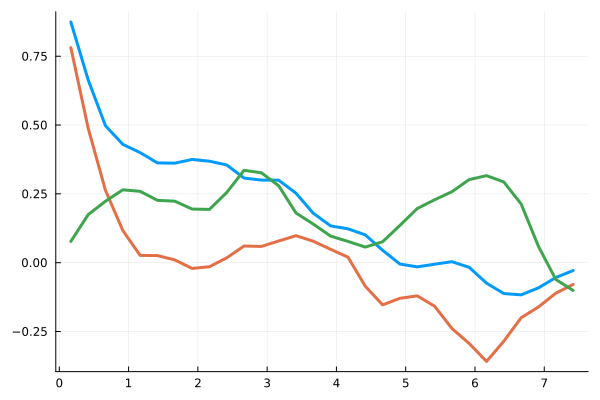

In [53]:
file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/movie2-cell1.tif" # bad. polarizes at very end of movie. 
file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/movie2-cell3.tif"
n=0
patches = mask_site(file, 0.5, n_sites=2)
patch1 = patches[:,:,:,1]
patch2 = patches[:,:,:,2]
max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
times_max2 = crop_times(max_patch2, 15*(60/5), 0.5)
crop1 = max_patch1[max(times_max1, times_max2)]
crop2 = max_patch2[max(times_max1, times_max2)]
ac1 = crosscor(crop1, crop1, 0:100)
ac2 = crosscor(crop2, crop2, 0:100)
xcor = crosscor(crop1, crop2, 0:100)
n+=2
t_cor = range(0,100)*(5/60)
plot(t_cor[range(1,30)*3], ac1[range(1,30)*3], x_ticks=0:8, label=false, color=1, linewidth=3)
plot!(t_cor[range(1,30)*3], ac2[range(1,30)*3], x_ticks=0:8, label=false, color=2, linewidth=3)
plot!(t_cor[range(1,30)*3], xcor[range(1,30)*3], x_ticks=0:8, label=false, color=3, linewidth=3)
#savefig("../figures/2patch_ac_2_4.png")

.

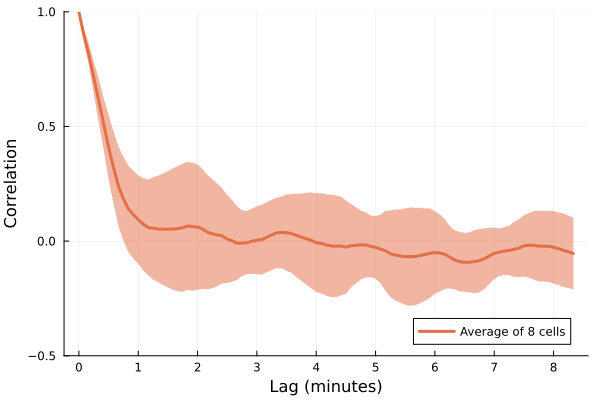

In [152]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/"
wt_files = readdir(dir)
plot(ylabel="Correlation", xlabel="Lag (minutes)",
    legend=:bottomright, size=(600,400))
all_cor = zeros(101, length(wt_files))
t_cor = range(0,100)*(5/60)
n = 0
for f in wt_files
    patches = mask_site("$dir$f", n_sites=2)
    patch1 = patches[:,:,:,1]
    patch2 = patches[:,:,:,2]
    max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
    max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
    times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
    times_max2 = crop_times(max_patch2, 15*(60/5), 0.5)
    crop1 = max_patch1[max(times_max1, times_max2)]
    cor1 = crosscor(crop1, crop1, 0:100)
    n+=1
    all_cor[:,n] = cor1
end
stdev = std(all_cor, dims=2)
plot!(t_cor, mean(all_cor, dims=2), ribbon=stdev, x_ticks=0:8, linewidth=3, color=2, alpha=1, label="Average of $(Int(n)) cells", ylim=(-0.5,1))

.

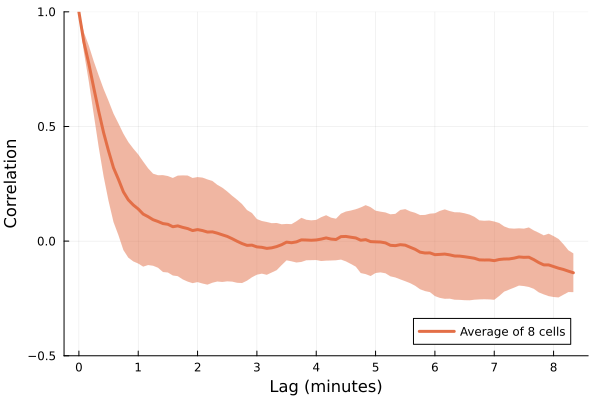

In [153]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/"
wt_files = readdir(dir)
plot(ylabel="Correlation", xlabel="Lag (minutes)",
    legend=:bottomright, size=(600,400))
all_cor = zeros(101, length(wt_files))
t_cor = range(0,100)*(5/60)
n = 0
for f in wt_files
    patches = mask_site("$dir$f", n_sites=2)
    patch1 = patches[:,:,:,1]
    patch2 = patches[:,:,:,2]
    max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
    max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
    times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
    times_max2 = crop_times(max_patch2, 15*(60/5), 0.5)
    crop1 = max_patch1[max(times_max1, times_max2)]
    crop2 = max_patch2[max(times_max1, times_max2)]
    cor2 = crosscor(crop2, crop2, 0:100)
    n+=1
    all_cor[:,n] = cor2
end
stdev = std(all_cor, dims=2)
plot!(t_cor, mean(all_cor, dims=2), ribbon=stdev, x_ticks=0:8, linewidth=3, color=2, alpha=1, label="Average of $(Int(n)) cells", ylim=(-0.5,1))

.

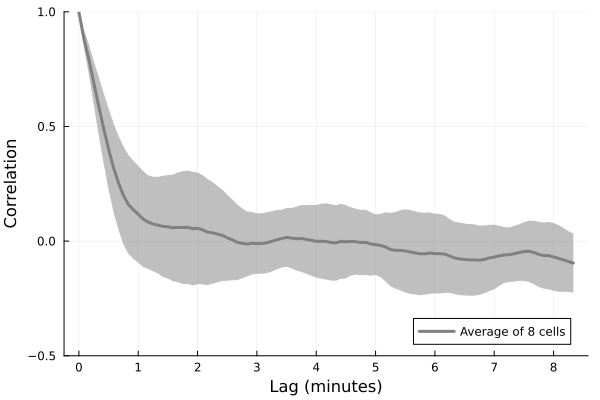

In [150]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/"
wt_files = readdir(dir)
plot(ylabel="Correlation", xlabel="Lag (minutes)",
    legend=:bottomright, size=(600,400))
all_cor = zeros(101, length(wt_files)*2)
t_cor = range(0,100)*(5/60)
n = 0
for f in wt_files
    patches = mask_site("$dir$f", n_sites=2)
    patch1 = patches[:,:,:,1]
    patch2 = patches[:,:,:,2]
    max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
    max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
    times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
    times_max2 = crop_times(max_patch2, 15*(60/5), 0.5)
    crop1 = max_patch1[max(times_max1, times_max2)]
    crop2 = max_patch2[max(times_max1, times_max2)]
    cor1 = crosscor(crop1, crop1, 0:100)
    cor2 = crosscor(crop2, crop2, 0:100)
    all_cor[:,n+1] = cor1
    all_cor[:,n+2] = cor2
    n+=2
end
stdev = std(all_cor, dims=2)
plot!(t_cor, mean(all_cor, dims=2), ribbon=stdev, x_ticks=0:8, linewidth=3, color="grey", alpha=1, label="Average of $(Int(n/2)) cells", ylim=(-0.5,1))

..

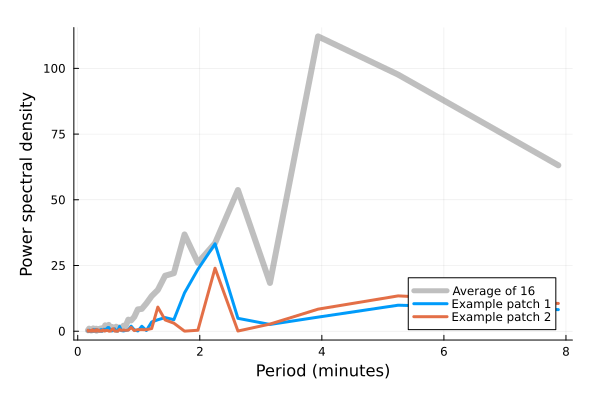

In [115]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/"
wt_files = readdir(dir)
plot(ylabel="Power spectral density", xlabel="Period (minutes)",
    legend=:bottomright, size=(600,400))
max_powers = zeros(95)
n = 0
for f in wt_files
    patches = mask_site("$dir$f", n_sites=2)
    patch1 = patches[:,:,:,1]
    patch2 = patches[:,:,:,2]
    max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
    max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
    times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
    times_max2 = crop_times(max_patch2, 15*(60/5), 0.5)
    crop1 = max_patch1[max(times_max1, times_max2)]
    crop2 = max_patch2[max(times_max1, times_max2)]
    pdg_max1 = DSP.Periodograms.periodogram(crop1)
    pdg_max2 = DSP.Periodograms.periodogram(crop2)
    max_powers = max_powers .+ pdg_max1.power
    max_powers = max_powers .+ pdg_max2.power
    frequencies = pdg_max1.freq
    global frequencies
    n+=2
end
plot!(1 ./ frequencies[3:end] .* (5/60), max_powers[3:end]/n, xflip = false, 
    label="Average of $n", linewidth=6, alpha=0.5, margin=5Plots.mm, color="grey")

file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/movie2-cell4.tif"
patches = mask_site(file, n_sites=2)
patch1 = patches[:,:,:,1]
patch2 = patches[:,:,:,2]
max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
times_max2 = crop_times(max_patch2, 15*(60/5), 0.5)
crop1 = max_patch1[max(times_max1, times_max2)]
crop2 = max_patch2[max(times_max1, times_max2)]
pdg_max1 = DSP.Periodograms.periodogram(crop1)
pdg_max2 = DSP.Periodograms.periodogram(crop2)
plot!(1 ./ frequencies[3:end] .* (5/60), pdg_max1.power[3:end], xflip = false, 
    label="Example patch 1", linewidth=3, alpha=1, margin=5Plots.mm, color=1)
plot!(1 ./ frequencies[3:end] .* (5/60), pdg_max2.power[3:end], xflip = false, 
    label="Example patch 2", linewidth=3, alpha=1, margin=5Plots.mm, color=2)
#savefig("../figures/2patch_periodogram_2_4.png")

In [71]:
pos_max = findmax(all_cor)[2]*(5/60)

2.833333333333333

In [21]:
dir = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/"
wt_files = readdir(dir)
plot(ylabel="Correlation", xlabel="Lag (minutes)",
    legend=:bottomright, size=(600,400))
all_cor = zeros(101, length(wt_files)*2)
t_cor = range(0,100)*(5/60)
n = 0
for f in wt_files
    patches = mask_site("$dir$f", n_sites=2)
    patch1 = patches[:,:,:,1]
    patch2 = patches[:,:,:,2]
    max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
    max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
    times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
    times_max2 = crop_times(max_patch2, 15*(60/5), 0.5)
    crop1 = max_patch1[max(times_max1, times_max2)]
    crop2 = max_patch2[max(times_max1, times_max2)]
    cor1 = crosscor(crop1, crop2, -100:0)
    cor2 = crosscor(crop1, crop2, 0:100)
    all_cor[:,n+1] = cor1
    all_cor[:,n+2] = cor2
    n+=2
end
stdev = std(all_cor, dims=2)
plot!(t_cor, mean(all_cor, dims=2), ribbon=stdev, x_ticks=1:8, linewidth=3, color="grey", alpha=1, label="Average of $(Int(n/2)) cells", ylim=(-0.5,1))

file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/2patch/movie2-cell4.tif"
patches = mask_site(file, n_sites=2)
patch1 = patches[:,:,:,1]
patch2 = patches[:,:,:,2]
max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
times_max2 = crop_times(max_patch2, 15*(60/5), 0.5)
crop1 = max_patch1[max(times_max1, times_max2)]
crop2 = max_patch2[max(times_max1, times_max2)]
xcor = crosscor(crop1, crop2, 0:100)

t_cor = range(0,100)*(5/60)

#plot!(t_cor, xcor, x_ticks=0:8, label=false, color=3, linewidth=3)
#savefig("../figures/avg_ac.png")

..

"/home/dinosaur/Lab/Polarity/proj/fig4-patchDynamics/figures/avg_ac.png"

In [14]:
function mask_site(file; n_sites=1)
    img = load(file)
    im_array = Float64.(img)
    frame_avg = mean(im_array, dims=(1,2))
    # Do frame averaging
    im_array = im_array ./ frame_avg
    # Do mean value subtraction
    im_array = im_array .- mean(im_array)
    # Use stack sum projection to find polarity patch(es)
    avgimg = mean(im_array, dims=(3))[:,:,1]
    max_bin = 0
    threshold = 0.45
    bin = avgimg .> maximum(avgimg)*threshold
    bin_lab = label_components(bin)
    masks = zeros(size(im_array)[1], size(im_array)[2], size(im_array)[3], n_sites)
    for i in range(1,n_sites)
        bin = bin .- max_bin             # Half max of average is used as threshold
        max_loc = findmax(bin.*avgimg)[2]              # Find single connected component from binary with highest value
        max_lab = bin_lab[max_loc]                  
        max_bin = bin_lab .== max_lab               # Make mask only around correct component
        im_masked = im_array .* max_bin
        masks[:,:,:,i] = im_masked
    end
    return masks
end

mask_site (generic function with 1 method)

In [15]:

file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/zmax_2patch/cell2.tif"
patches = mask_site(file, n_sites=2)
patch1 = patches[:,:,:,1]
patch2 = patches[:,:,:,2]
max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
t = range(1,length(max_patch1))*(5/60) # Convert from 1 frame every 5 sec, to minutes
plot(t, max_patch1, linewidth=2, xlabel="Time (minutes)", label=false,
    ylabel="Fluoresence", size=(800,200), margin=5Plots.mm, xticks=0:1:15)
plot!(t, max_patch2, linewidth=2, color=2, label=false)
#savefig("../figures/2patch_trace_max.png")

"/home/dinosaur/Lab/Polarity/proj/fig4-patchDynamics/figures/2patch_trace_max.png"

In [103]:
file = "../movies-Pak1-GFP/2024_07_08-PolProbeMovies/zmax_2patch/cell2.tif"
n=0
patches = mask_site(file, n_sites=2)
patch1 = patches[:,:,:,1]
patch2 = patches[:,:,:,2]
max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
max_patch2 = maximum(patch2, dims=(1,2))[1,1,:]
ac1 = crosscor(crop1, crop1, 0:100)
ac2 = crosscor(crop2, crop2, 0:100)
xcor = crosscor(crop1, crop2, 0:100)
n+=2
t_cor = range(0,100)*(5/60)
plot(t_cor, ac1, x_ticks=0:8, label=false, color=1, linewidth=3)
plot!(t_cor, ac2, x_ticks=0:8, label=false, color=2, linewidth=3)
plot!(t_cor, xcor, x_ticks=0:8, label=false, color=3, linewidth=3)
#savefig("../figures/2patch_ac_2_4.png")

-0.3350724194901477